## Importing the Data <a id='importing_the_data'></a>

<hr style="border:1px solid gray">

In [ ]:
import sys
!{sys.executable} -m pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

darwin = fetch_ucirepo(id=732)

features = darwin.data.features
target = darwin.data.targets

<hr style="border:2px solid gray">

# Final Project: Training a Classifier to Distinguish Patients With and Without Alzheimer's (PCA + Naive Bayes)

The dataset has been taken from UCI's machine learning repo. https://doi.org/10.24432/C55D0K

<hr style="border:1px solid gray">

## Index: <a id='index'></a>
1. [Problem Formulation](#prob_form)
2. [Data Preparation](#data_prep)
3. [Dimensionality Reduction](#pca)
4. [Simple Classifier 1: Decision Tree](#dec_tree)
5. [Simple Classifier 2: Gaussian Naive Bayes](#gauss_nb)
6. [Learning Curves](#lrn_curves)
7. [Hyperparameter Tuning](#hyp_prm_tuning)
8. [Results & Discussion](#res_and_disc)

<hr style="border:2px solid gray">

## Problem Formulation <a id='prob_form'></a>

<hr style="border:1px solid gray">

Early detection of Alzheimer's disease is quite difficult as the symptoms are varied and often start showing slowly. Therefore, it would be useful to employ machine learning algorithms to classify patients as either healthy or at-risk based on information related to the symptoms. This would allow for the monitoring of symptoms over an extended period of time without consuming too much of individual doctors' or nurses' time. In this exercise, we make an attempt to train such a classification model, with the specific symptom of focus being handwriting. The DARWIN dataset is used for training as it provides information about over 170 participants of a handwriting study related to Alzheimer's disease, and it is already labelled.

Due to the extremely high dimensionality of the dataset, we begin by reducing the number of features through principal component analysis. On another hand, due to the dataset also being relatively small, simple classification models are considered to reduce overfitting.

## Data Preparation <a id='data_prep'></a>

<hr style="border:1px solid gray">

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd

from scipy     import stats
from sklearn   import metrics
from sklearn.preprocessing   import StandardScaler, LabelEncoder
from sklearn.decomposition   import PCA
from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     cross_val_predict, cross_val_score,
                                     learning_curve, GridSearchCV)
from sklearn.tree            import DecisionTreeClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.pipeline        import make_pipeline

As the dataset is extremely high-dimensional, with over 450 features, it is not sensible to check each column by eye. Additionally, with such a surplus of features, it also makes sense to simply cut out any non-numerical feature (unless they are the majority of features).

Therefore, checking for "object" types, we find the below feature:

In [ ]:
features.select_dtypes("object").head()
# useful ------> encoded
# not useful --> removed

,ID
0,id_1
1,id_2
2,id_3
3,id_4
4,id_5


This is the only "object" type column, and actually not a feature at all; only a duplicate of the row index. Therefore cutting makes sense. All other features can be assumed to be numerical.

In [ ]:
features = features.drop(columns="ID")

Similarly, we now check the targets. As this is a single-column dataframe, we can simply use `.head()`.

In [ ]:
target.head()

,class
0,P
1,P
2,P
3,P
4,P


These look fine, however, we need them encoded as 1s and 0s for scikit-learn.

In [ ]:
target = LabelEncoder().fit_transform(target)
# H --> 0
# P --> 1

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("There are {} null values in the features dataset.".format(features.isnull().sum().sum()))
print("There are {} null values in the target dataset.".format(np.isnan(target).sum()))

There are 0 null values in the features dataset.
There are 0 null values in the target dataset.


## Dimensionality Reduction <a id='pca'></a>

<hr style="border:1px solid gray">

The dataset as is has too many dimensions. The chances are unlikely that every feature will contribute equally when we go on to training the model. Principal component analysis (PCA) is the tool that will allow us to rank the features in accordance to how much they contribute towards the overall variance of the dataset.

Essentially, the assumption here is that features that encode the most variance will also be the ones that will contribute the most when informing our model when in training.

The first step of PCA is always scaling the dataset. This is because, for example, any feature with a comparatively large range, will also have a higher variance which will in turn return misleading scores (eigenvalues), making our PCA ranking wrong.

In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

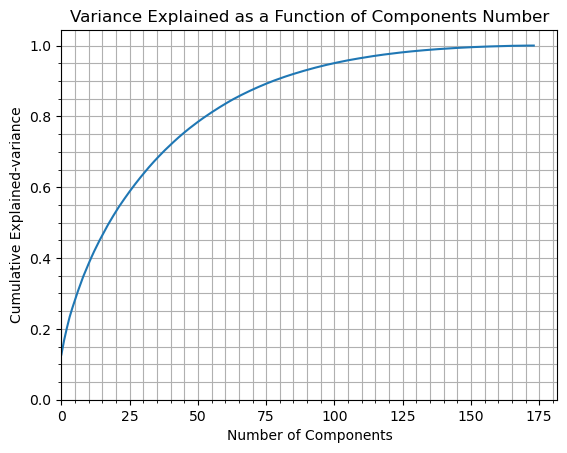

In [ ]:
pca_max = PCA(n_components=features.shape[0], random_state=0)
features_projected_max = pca_max.fit_transform(features)

plt.plot(np.cumsum(pca_max.explained_variance_ratio_))

plt.grid(which="both")
plt.minorticks_on()

plt.xlim(0,)
plt.ylim(0,)

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained-variance")
plt.title("Variance Explained as a Function of Components Number");

In [ ]:
pca_100 = PCA(n_components=100, random_state=0)
features_100 = pca_100.fit_transform(features)
var_total_100 = np.cumsum(pca_100.explained_variance_ratio_)[-1]
print("Total described variance (100D): {:.1f}%.".format(var_total_100*100))

pca_50 = PCA(n_components=50, random_state=0)
features_50 = pca_50.fit_transform(features)
var_total_50 = np.cumsum(pca_50.explained_variance_ratio_)[-1]
print("Total described variance (50D):  {:.1f}%.".format(var_total_50*100))

pca_10 = PCA(n_components=10, random_state=0)
features_10 = pca_10.fit_transform(features)
var_total_10 = np.cumsum(pca_10.explained_variance_ratio_)[-1]
print("Total described variance (10D):  {:.1f}%.".format(var_total_10*100))

pca_5 = PCA(n_components=5, random_state=0)
features_5 = pca_5.fit_transform(features)
var_total_5 = np.cumsum(pca_5.explained_variance_ratio_)[-1]
print("Total described variance (5D):   {:.1f}%.".format(var_total_5*100))

Total described variance (100D): 94.9%.
Total described variance (50D):  77.9%.
Total described variance (10D):  36.7%.
Total described variance (5D):   25.9%.


PCA is performed four times on the dataset, projecting the features dataset to a new 100-, 50, -10, and 5-dimensional datasets, respectively. The plot above shows the loss in percentage variance-described as we go from the initial ~170-dimensional dataset down to 1-dimension only.

Also listed above, are the variance-described percentages at the aforementioned n-dimensions. From the graph, we can also see that a single component can also describe up to $\sim17\%$ of the total variance in the dataset on its own.

With this prepared, we can now begin training some classification models.

## Simple Classifier 1: Decision Tree <a id='dec_tree'></a>

<hr style="border:1px solid gray">

Due to the small size of the dataset (now referring to the low number of rows), simple classification models are preferred.

Therefore, we first try training a model with a decision tree. Shuffled, stratified k-fold cross validation is also used to obtain recall scores. Recall is chosen as our metric due to the nature of the problem as we specifically care about reducing the amount of false negatives (people with Alzheimer's disease being misclassified as healthy).

In [ ]:
cv_skf = StratifiedKFold(shuffle=True, n_splits=5, random_state=0)

In [ ]:
print("Recall:")
print("")

scores_100 = cross_validate(DecisionTreeClassifier(), features_100, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (100D): {:.2} +/- {:.2}".format(scores_100['test_score'].mean(), scores_100['test_score'].std()))
print("Train score (100D): {:.2} +/- {:.2}".format(scores_100['train_score'].mean(), scores_100['train_score'].std()))
print("")

scores_50 = cross_validate(DecisionTreeClassifier(), features_50, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (50D): {:.2} +/- {:.2}".format(scores_50['test_score'].mean(), scores_50['test_score'].std()))
print("Train score (50D): {:.2} +/- {:.2}".format(scores_50['train_score'].mean(), scores_50['train_score'].std()))
print("")

scores_10 = cross_validate(DecisionTreeClassifier(), features_10, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (10D): {:.2} +/- {:.2}".format(scores_10['test_score'].mean(), scores_10['test_score'].std()))
print("Train score (10D): {:.2} +/- {:.2}".format(scores_10['train_score'].mean(), scores_10['train_score'].std()))
print("")

scores_5 = cross_validate(DecisionTreeClassifier(), features_5, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (5D):   {:.2} +/- {:.2}".format(scores_5['test_score'].mean(), scores_5['test_score'].std()))
print("Train score (5D):   {:.2} +/- {:.2}".format(scores_5['train_score'].mean(), scores_5['train_score'].std()))

Recall:

Test score  (100D): 0.7 +/- 0.11
Train score (100D): 1.0 +/- 0.0

Test score  (50D): 0.72 +/- 0.12
Train score (50D): 1.0 +/- 0.0

Test score  (10D): 0.79 +/- 0.072
Train score (10D): 1.0 +/- 0.0

Test score  (5D):   0.77 +/- 0.14
Train score (5D):   1.0 +/- 0.0


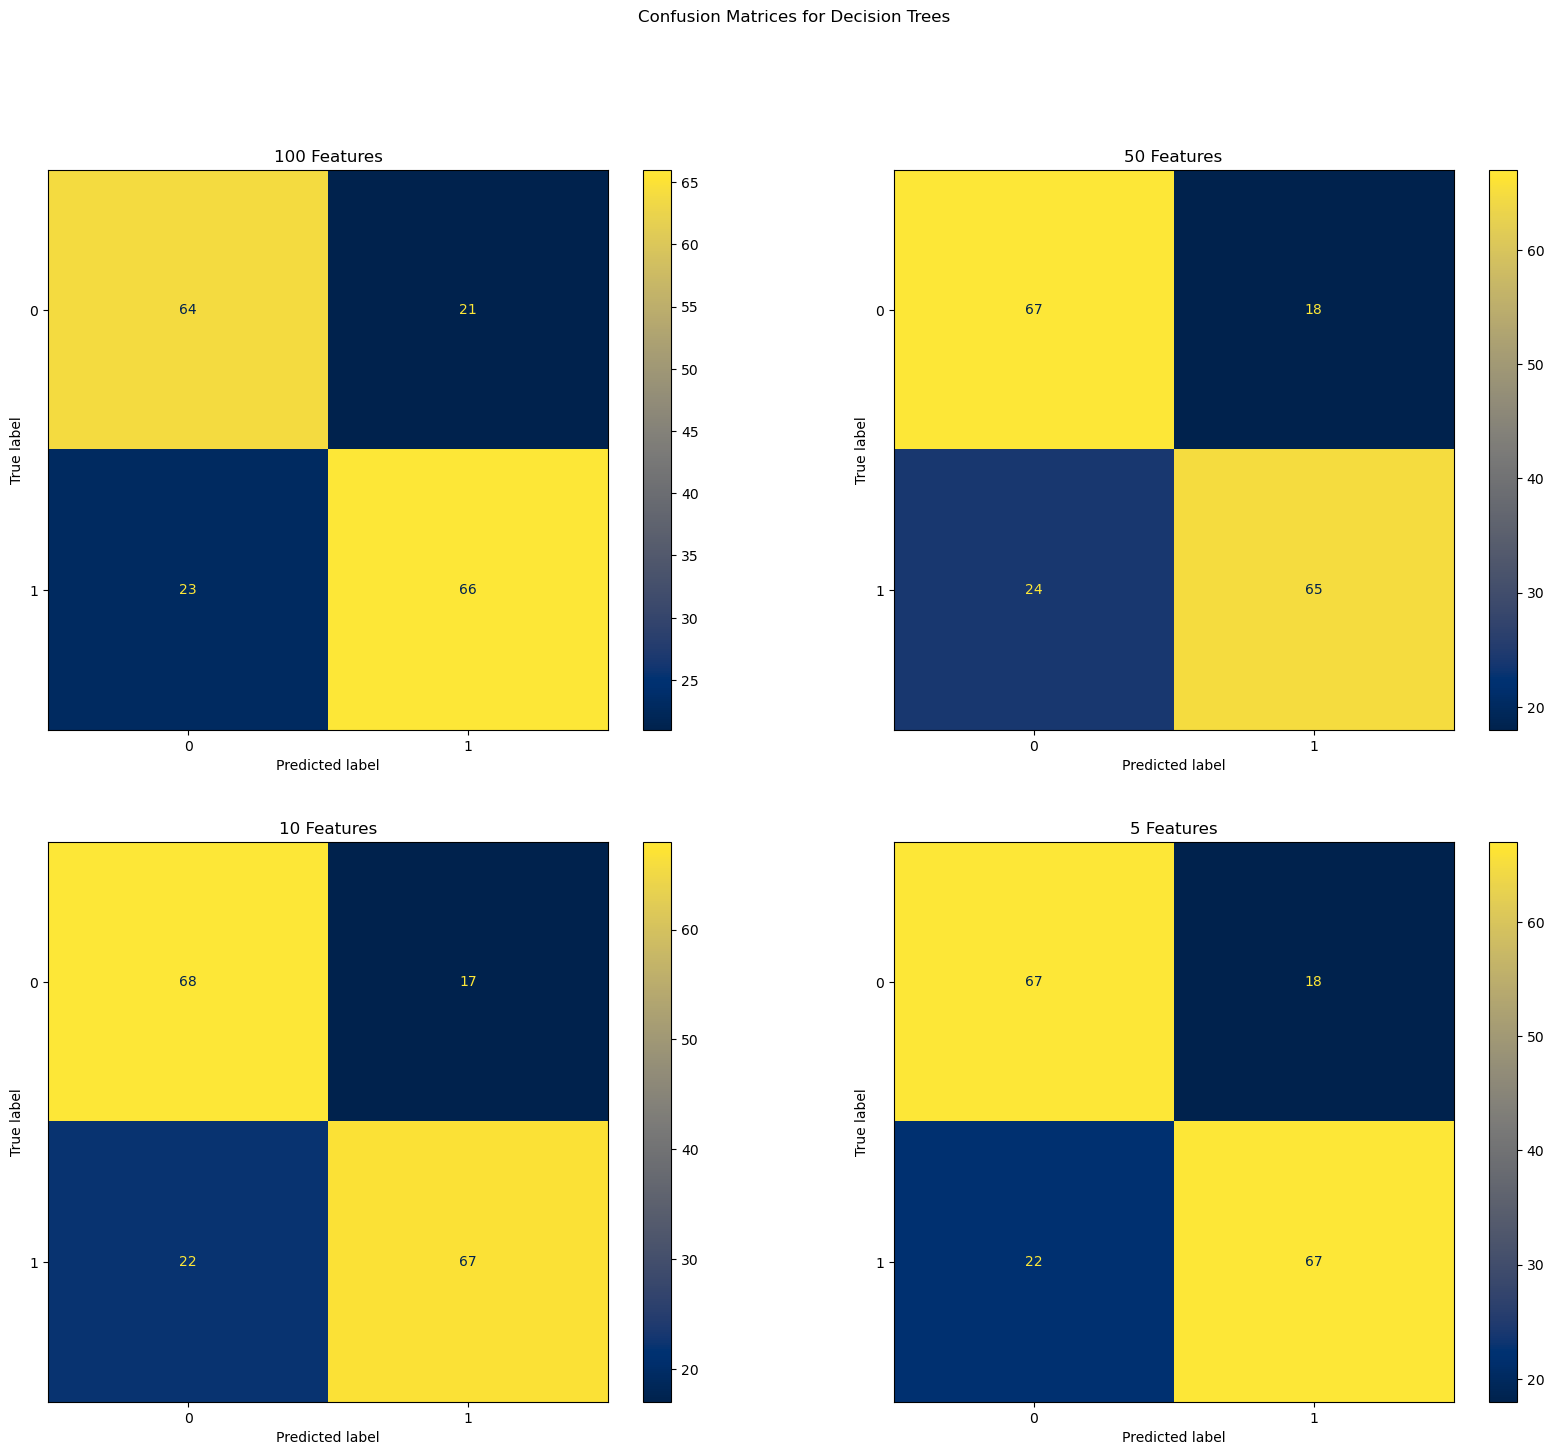

In [ ]:
predy_100 = cross_val_predict(DecisionTreeClassifier(), features_100, target, cv=cv_skf)
predy_50 = cross_val_predict(DecisionTreeClassifier(), features_50, target, cv=cv_skf)
predy_10 = cross_val_predict(DecisionTreeClassifier(), features_10, target, cv=cv_skf)
predy_5 = cross_val_predict(DecisionTreeClassifier(), features_5, target, cv=cv_skf)

cm_100 = metrics.confusion_matrix(target, predy_100)
cm_50 = metrics.confusion_matrix(target, predy_50)
cm_10 = metrics.confusion_matrix(target, predy_10)
cm_5 = metrics.confusion_matrix(target, predy_5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

metrics.ConfusionMatrixDisplay(confusion_matrix=cm_100).plot(cmap="cividis", ax=ax[0,0])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_50).plot(cmap="cividis", ax=ax[0,1])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_10).plot(cmap="cividis", ax=ax[1,0])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_5).plot(cmap="cividis", ax=ax[1,1])

ax[0,0].set_title("100 Features")
ax[0,1].set_title("50 Features")
ax[1,0].set_title("10 Features")
ax[1,1].set_title("5 Features")

fig.suptitle("Confusion Matrices for Decision Trees");

## Simple Classifier 2: Gaussian Naive Bayes <a id='gauss_nb'></a>

<hr style="border:1px solid gray">

In [ ]:
print("Recall:")
print("")

scores_100 = cross_validate(GaussianNB(), features_100, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (100D): {:.2} +/- {:.2}".format(scores_100['test_score'].mean(), scores_100['test_score'].std()))
print("Train score (100D): {:.2} +/- {:.2}".format(scores_100['train_score'].mean(), scores_100['train_score'].std()))
print("")

scores_50 = cross_validate(GaussianNB(), features_50, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (50D): {:.2} +/- {:.2}".format(scores_50['test_score'].mean(), scores_50['test_score'].std()))
print("Train score (50D): {:.2} +/- {:.2}".format(scores_50['train_score'].mean(), scores_50['train_score'].std()))
print("")

scores_10 = cross_validate(GaussianNB(), features_10, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (10D): {:.2} +/- {:.2}".format(scores_10['test_score'].mean(), scores_10['test_score'].std()))
print("Train score (10D): {:.2} +/- {:.2}".format(scores_10['train_score'].mean(), scores_10['train_score'].std()))
print("")

scores_5 = cross_validate(GaussianNB(), features_5, target, cv = cv_skf, scoring = "recall", return_train_score=True)
print("Test score  (5D):   {:.2} +/- {:.2}".format(scores_5['test_score'].mean(), scores_5['test_score'].std()))
print("Train score (5D):   {:.2} +/- {:.2}".format(scores_5['train_score'].mean(), scores_5['train_score'].std()))

Recall:

Test score  (100D): 0.81 +/- 0.11
Train score (100D): 0.88 +/- 0.013

Test score  (50D): 0.76 +/- 0.087
Train score (50D): 0.81 +/- 0.028

Test score  (10D): 0.72 +/- 0.18
Train score (10D): 0.78 +/- 0.033

Test score  (5D):   0.71 +/- 0.11
Train score (5D):   0.75 +/- 0.025


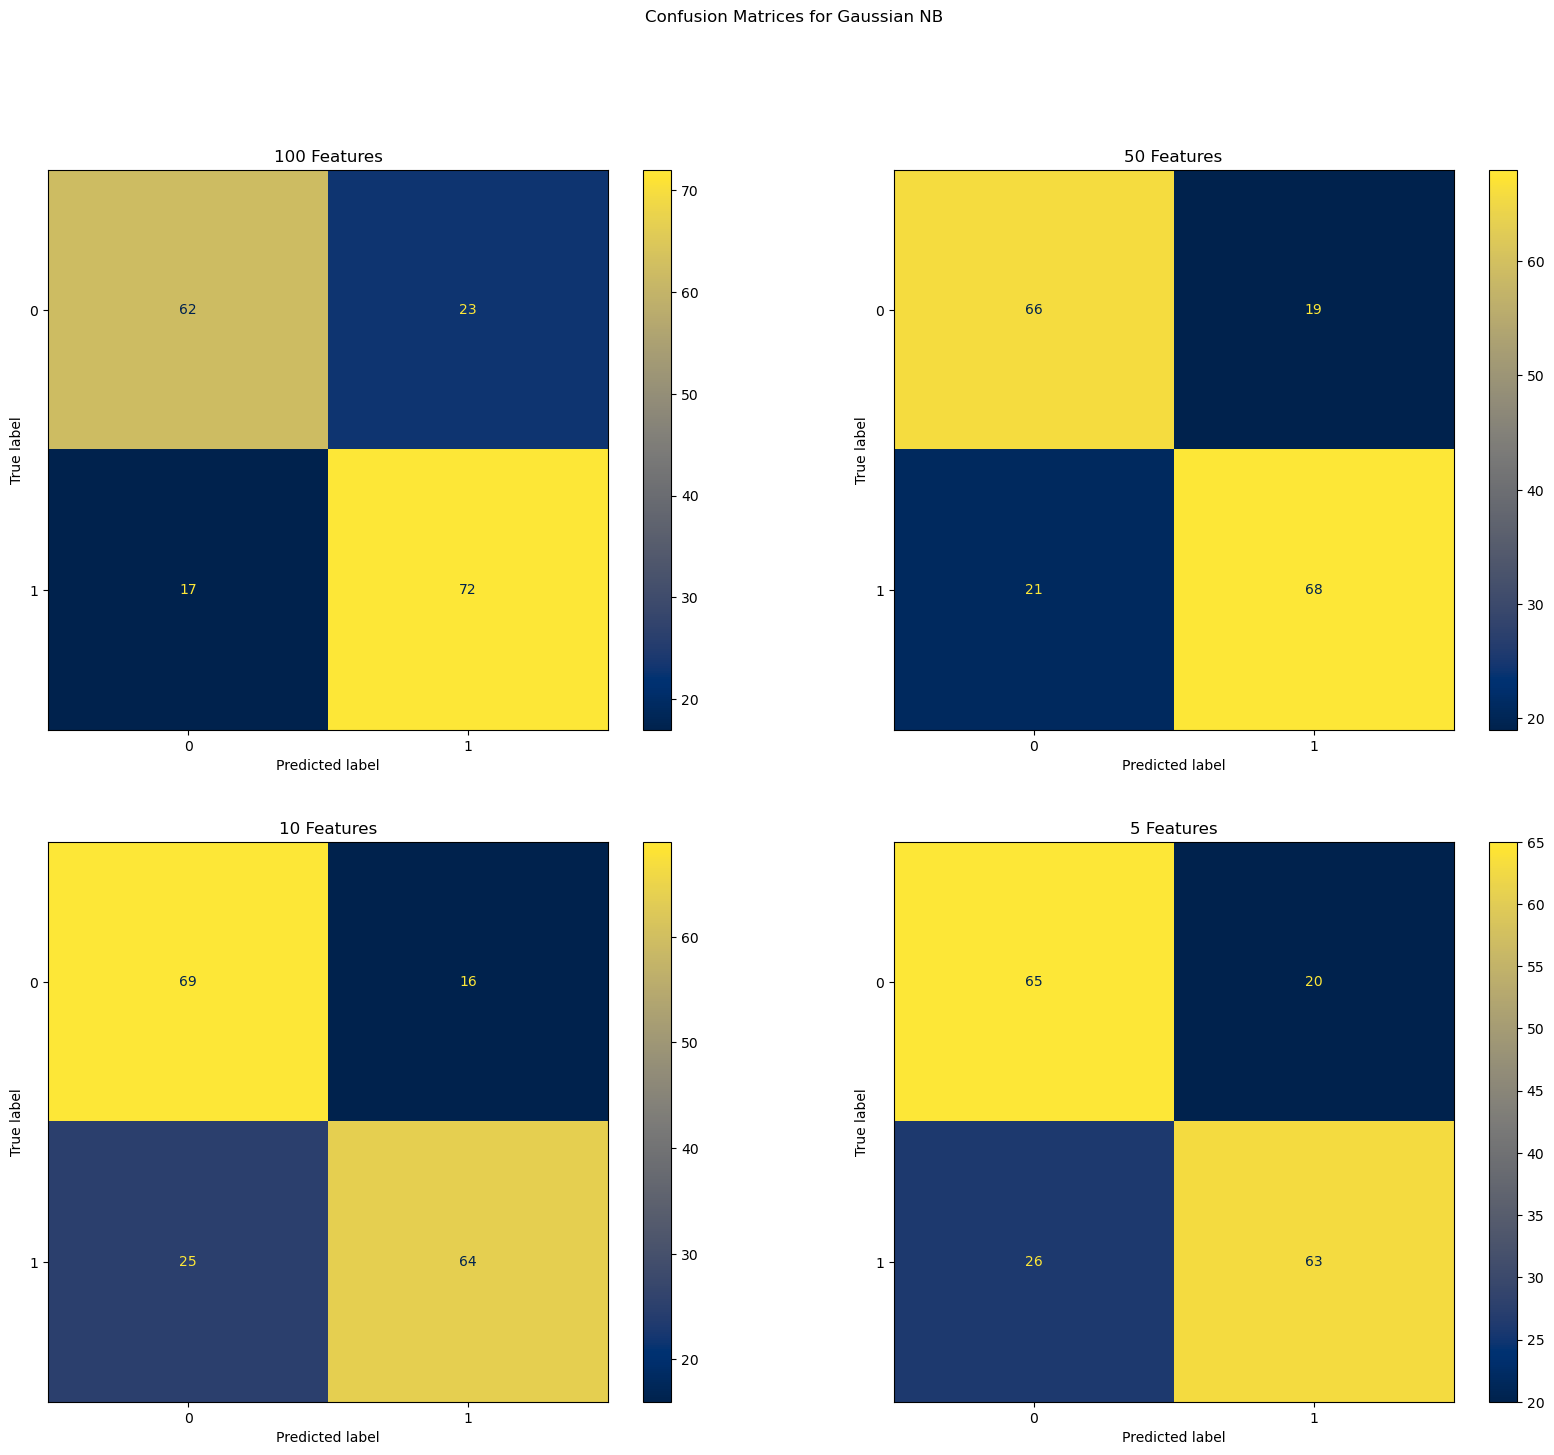

In [ ]:
predy_100 = cross_val_predict(GaussianNB(), features_100, target, cv=cv_skf)
predy_50 = cross_val_predict(GaussianNB(), features_50, target, cv=cv_skf)
predy_10 = cross_val_predict(GaussianNB(), features_10, target, cv=cv_skf)
predy_5 = cross_val_predict(GaussianNB(), features_5, target, cv=cv_skf)

cm_100 = metrics.confusion_matrix(target, predy_100)
cm_50 = metrics.confusion_matrix(target, predy_50)
cm_10 = metrics.confusion_matrix(target, predy_10)
cm_5 = metrics.confusion_matrix(target, predy_5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

metrics.ConfusionMatrixDisplay(confusion_matrix=cm_100).plot(cmap="cividis", ax=ax[0,0])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_50).plot(cmap="cividis", ax=ax[0,1])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_10).plot(cmap="cividis", ax=ax[1,0])
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_5).plot(cmap="cividis", ax=ax[1,1])

ax[0,0].set_title("100 Features")
ax[0,1].set_title("50 Features")
ax[1,0].set_title("10 Features")
ax[1,1].set_title("5 Features")

fig.suptitle("Confusion Matrices for Gaussian NB");

Without tuning hyperparameters, both the Decision Tree Classification models and the Gaussian Naive-Bayes Classification models perform about the same, with model recall ranging between $~ 70-80\% \pm 10\%$.

However, it appears that the Decision Tree models perform better when trained on lower-dimensional data, whereas the Gaussian NB models perform better when trained on higher-dimensional data.

Interestingly, the recall score does not seem affected by the loss in the amount of variance encoded after PCA as the, lower-end, 5-feature dataset only encodes a cumulative variance of $25.9\% \pm 0.05\%$, but still results in recall scores of $80\% \pm 15\%$ (DecisionTree), and $71\% \pm 11\%$ (GaussianNB).

However, looking at train scores, it is quite clear that Decision Trees are overfitting, with perfect scores across the board. Therefore, going forward, hyperparameters will be tuned only for the Gaussian Naive-Bayes classifier.


## Learning Curves <a id='lrn_curves'></a>

<hr style="border:1px solid gray">

In [ ]:
# extra 1-dimensional feature space

pca_1 = PCA(n_components=1, random_state=0)
features_1 = pca_1.fit_transform(features)
var_total_1 = np.cumsum(pca_1.explained_variance_ratio_)[-1]
print("Total described variance (1D): {:.1f}%.".format(var_total_1*100))

Total described variance (1D): 12.8%.


In [ ]:
pipeline = make_pipeline(GaussianNB())

In [ ]:
train_sizes_100, train_scores_100, test_scores_100 = learning_curve(pipeline, features_100, target, cv = cv_skf, train_sizes = np.array([0.5,0.8,0.9,0.95,1.0]), scoring = "recall")
train_sizes_50, train_scores_50, test_scores_50 = learning_curve(pipeline, features_50, target, cv = cv_skf, train_sizes = np.array([0.5,0.8,0.9,0.95,1.0]), scoring = "recall")
train_sizes_10, train_scores_10, test_scores_10 = learning_curve(pipeline, features_10, target, cv = cv_skf, train_sizes = np.array([0.5,0.8,0.9,0.95,1.0]), scoring = "recall")
train_sizes_5, train_scores_5, test_scores_5 = learning_curve(pipeline, features_5, target, cv = cv_skf, train_sizes = np.array([0.5,0.8,0.9,0.95,1.0]), scoring = "recall")
train_sizes_1, train_scores_1, test_scores_1 = learning_curve(pipeline, features_1, target, cv = cv_skf, train_sizes = np.array([0.5,0.8,0.9,0.95,1.0]), scoring = "recall")


train_means_100 = train_scores_100.mean(axis=1)
test_means_100 = test_scores_100.mean(axis=1)
train_stds_100 = train_scores_100.std(axis=1)
test_stds_100 = test_scores_100.std(axis=1)

train_means_50 = train_scores_50.mean(axis=1)
test_means_50 = test_scores_50.mean(axis=1)
train_stds_50 = train_scores_50.std(axis=1)
test_stds_50 = test_scores_50.std(axis=1)

train_means_10 = train_scores_10.mean(axis=1)
test_means_10 = test_scores_10.mean(axis=1)
train_stds_10 = train_scores_10.std(axis=1)
test_stds_10 = test_scores_10.std(axis=1)

train_means_5 = train_scores_5.mean(axis=1)
test_means_5 = test_scores_5.mean(axis=1)
train_stds_5 = train_scores_5.std(axis=1)
test_stds_5 = test_scores_5.std(axis=1)

train_means_1 = train_scores_1.mean(axis=1)
test_means_1 = test_scores_1.mean(axis=1)
train_stds_1 = train_scores_1.std(axis=1)
test_stds_1 = test_scores_1.std(axis=1)

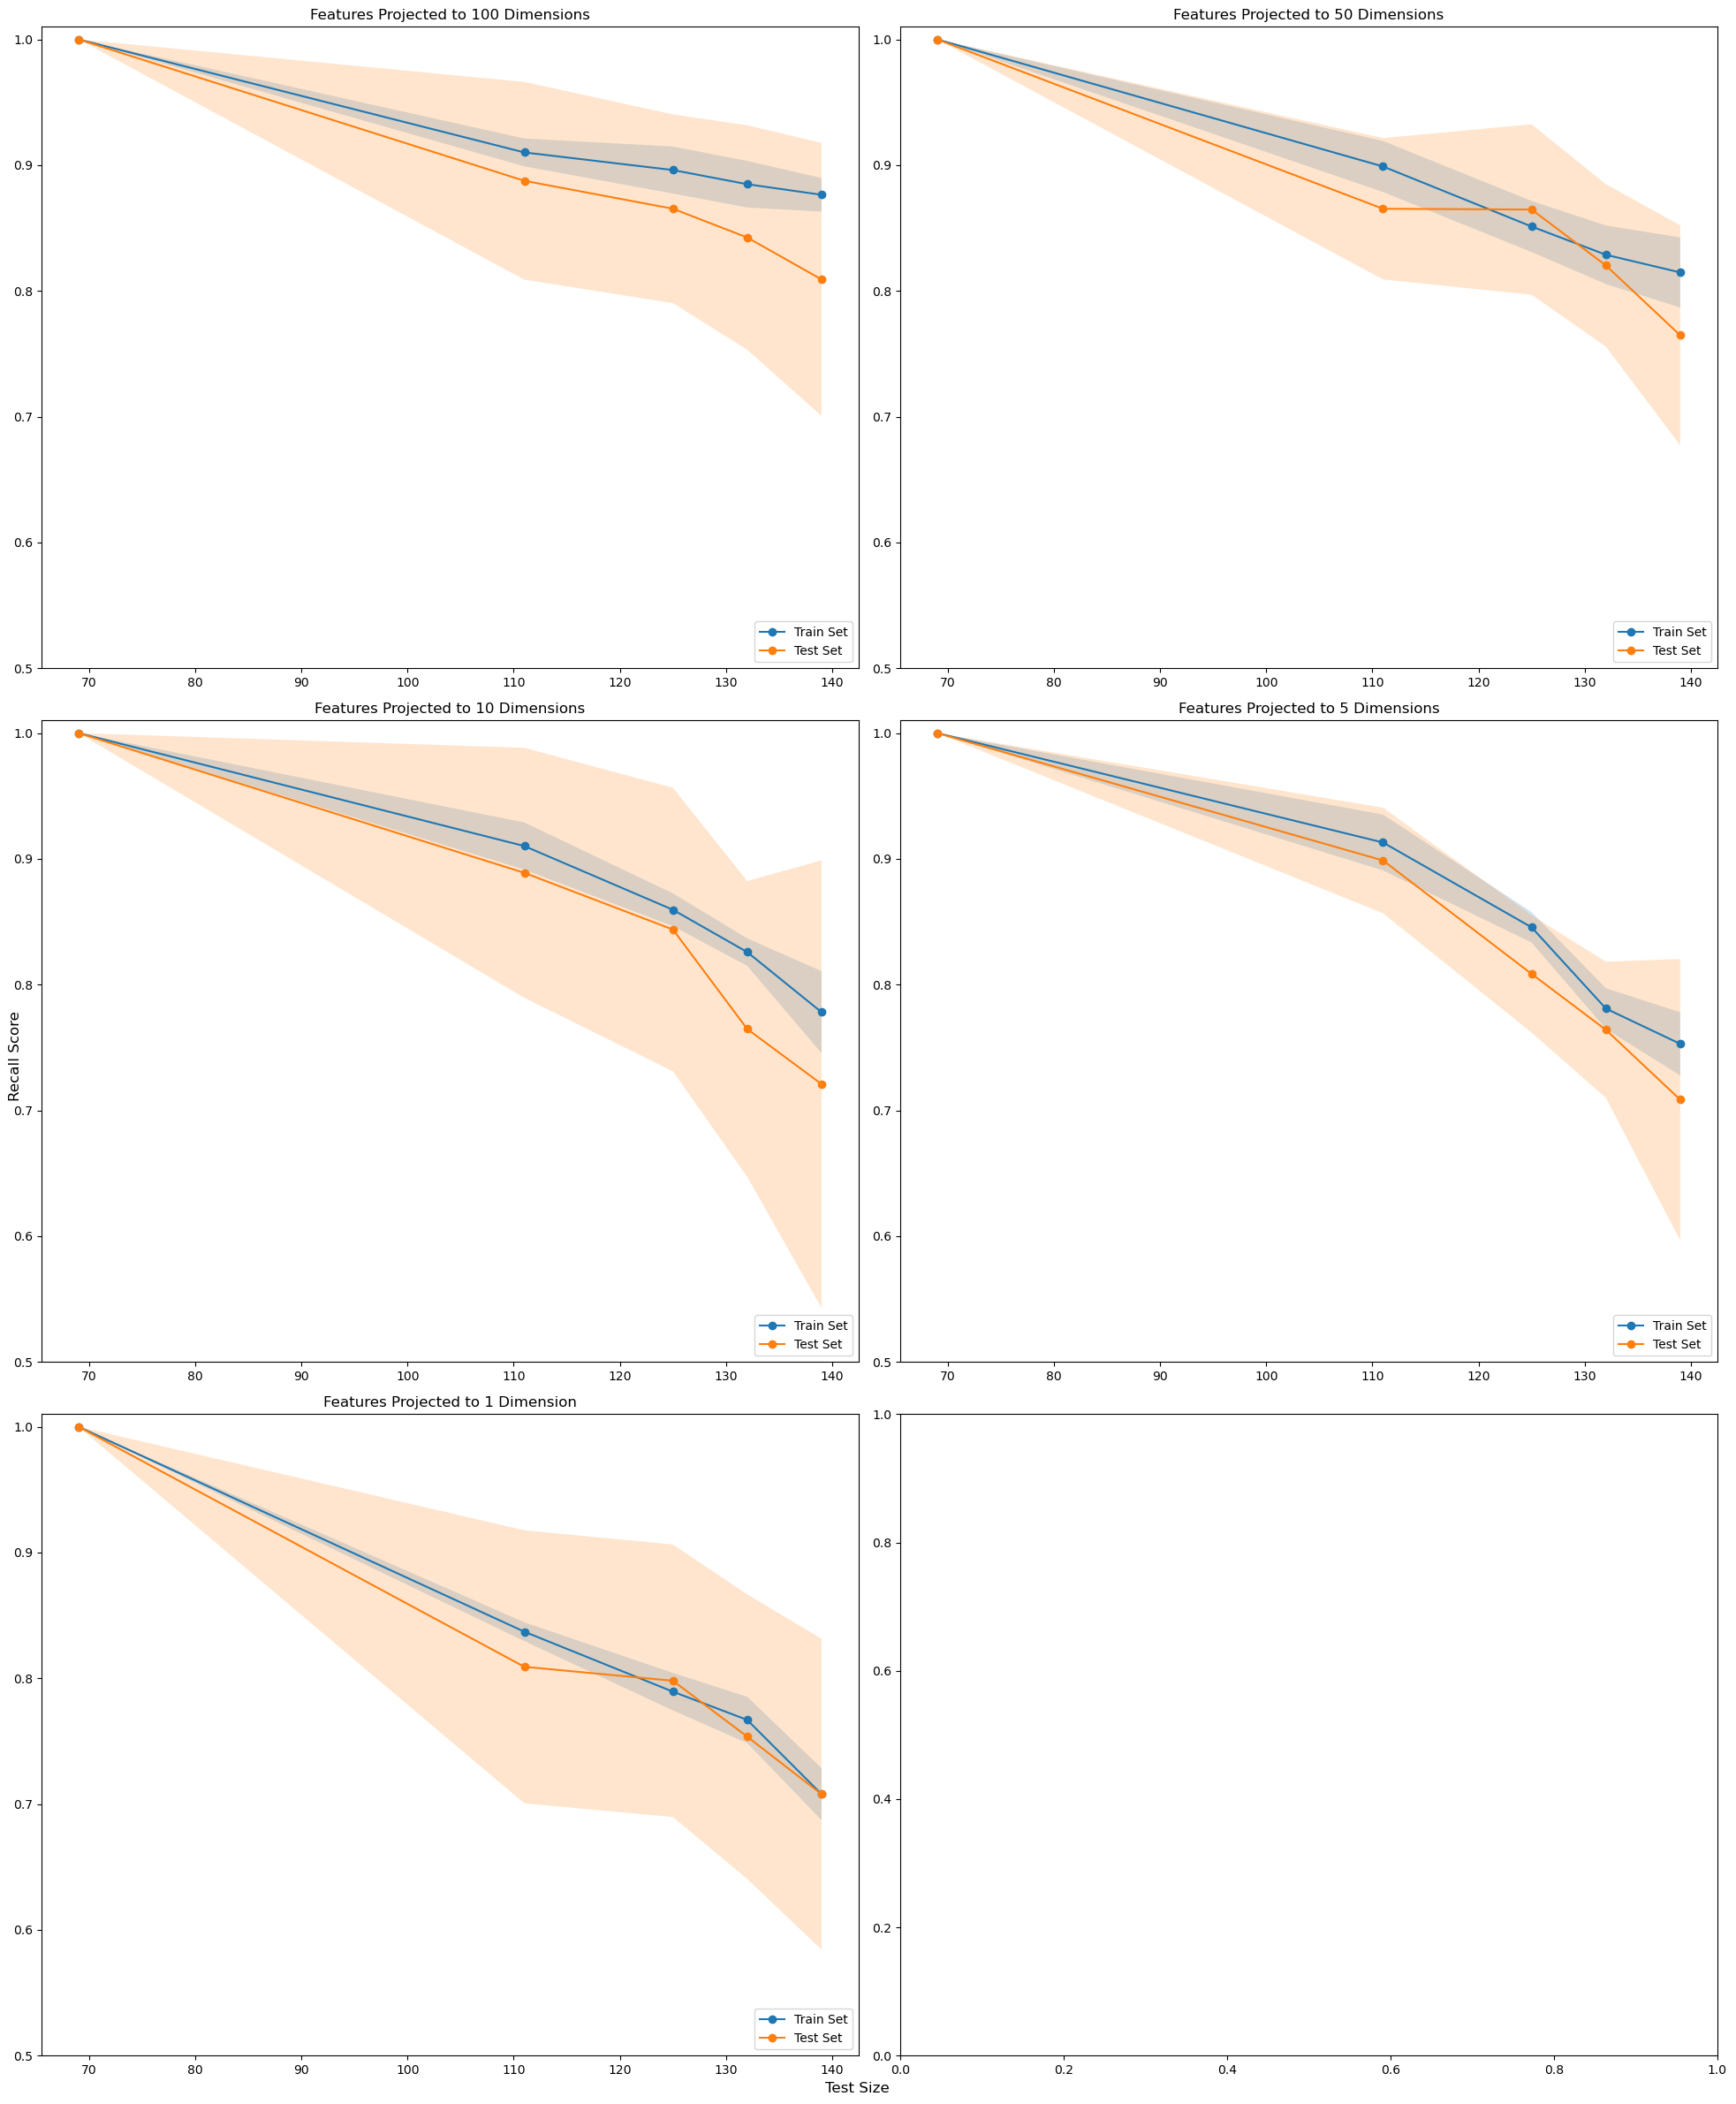

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 24))

ax[0,0].fill_between(train_sizes_100, train_means_100+train_stds_100, train_means_100-train_stds_100, alpha=0.2)
ax[0,0].plot(train_sizes_100, train_means_100, marker="o", label="Train Set")
ax[0,0].fill_between(train_sizes_100, test_means_100+test_stds_100, test_means_100-test_stds_100, alpha=0.2)
ax[0,0].plot(train_sizes_100, test_means_100, marker="o", label="Test Set")
ax[0,0].set_title("Features Projected to 100 Dimensions")
ax[0,0].legend(loc="lower right")
ax[0,0].set_ylim(0.5,1.01)

ax[0,1].fill_between(train_sizes_50, train_means_50+train_stds_50, train_means_50-train_stds_50, alpha=0.2)
ax[0,1].plot(train_sizes_50, train_means_50, marker="o", label="Train Set")
ax[0,1].fill_between(train_sizes_50, test_means_50+test_stds_50, test_means_50-test_stds_50, alpha=0.2)
ax[0,1].plot(train_sizes_50, test_means_50, marker="o", label="Test Set")
ax[0,1].set_title("Features Projected to 50 Dimensions")
ax[0,1].legend(loc="lower right")
ax[0,1].set_ylim(0.5,1.01)

ax[1,0].fill_between(train_sizes_10, train_means_10+train_stds_10, train_means_10-train_stds_10, alpha=0.2)
ax[1,0].plot(train_sizes_10, train_means_10, marker="o", label="Train Set")
ax[1,0].fill_between(train_sizes_10, test_means_10+test_stds_10, test_means_10-test_stds_10, alpha=0.2)
ax[1,0].plot(train_sizes_10, test_means_10, marker="o", label="Test Set")
ax[1,0].set_title("Features Projected to 10 Dimensions")
ax[1,0].legend(loc="lower right")
ax[1,0].set_ylim(0.5,1.01)

ax[1,1].fill_between(train_sizes_5, train_means_5+train_stds_5, train_means_5-train_stds_5, alpha=0.2)
ax[1,1].plot(train_sizes_5, train_means_5, marker="o", label="Train Set")
ax[1,1].fill_between(train_sizes_5, test_means_5+test_stds_5, test_means_5-test_stds_5, alpha=0.2)
ax[1,1].plot(train_sizes_5, test_means_5, marker="o", label="Test Set")
ax[1,1].set_title("Features Projected to 5 Dimensions")
ax[1,1].legend(loc="lower right")
ax[1,1].set_ylim(0.5,1.01)

ax[2,0].fill_between(train_sizes_1, train_means_1+train_stds_1, train_means_1-train_stds_1, alpha=0.2)
ax[2,0].plot(train_sizes_1, train_means_1, marker="o", label="Train Set")
ax[2,0].fill_between(train_sizes_1, test_means_1+test_stds_1, test_means_1-test_stds_1, alpha=0.2)
ax[2,0].plot(train_sizes_1, test_means_1, marker="o", label="Test Set")
ax[2,0].set_title("Features Projected to 1 Dimension")
ax[2,0].legend(loc="lower right")
ax[2,0].set_ylim(0.5,1.01)

fig.supxlabel("Test Size")
fig.supylabel("Recall Score")
plt.tight_layout();

Looking at the learning curves, the dataset with 5 features appears to perform the best. Although the 1-dimensional dataset has more closely agreeing training and testing recall scores, the error is smaller at 5-dimensions.

## Hyperparameter Tuning <a id='hyp_prm_tuning'></a>

<hr style="border:1px solid gray">

In [ ]:
print("The parameters are {0} and {1}.".format(*GaussianNB().get_params().keys()))

# from documentation:
# priors: array-like of shape (n_classes,), default=None
#   Prior probabilities of the classes.
#   If specified, the priors are not adjusted according to the data.
#
# keeping it None, i.e. priors will be adjusted based on data

The parameters are priors and var_smoothing.


In [ ]:
print("Default var_smoothing: 1e-9")

parameters = {"gaussiannb__var_smoothing": np.logspace(0, -9, num=100)}

cv_gs = GridSearchCV(pipeline, param_grid=parameters, return_train_score=True)

cv_gs.fit(features_5, target)

print("The best var_smoothing parameter is {gaussiannb__var_smoothing}.".format(**cv_gs.best_params_))
print("Recall test score after tuning {0:.2f}+\-{1:.2f}".format(*[cv_gs.cv_results_["mean_test_score"][cv_gs.best_index_],
                          cv_gs.cv_results_["std_test_score"][cv_gs.best_index_]]))
print("Recall train score after tuning {0:.2f}+\-{1:.2f}".format(*[cv_gs.cv_results_["mean_train_score"][cv_gs.best_index_],
                          cv_gs.cv_results_["std_train_score"][cv_gs.best_index_]]))

Default var_smoothing: 1e-9
The best var_smoothing parameter is 1.0.
Recall test score after tuning 0.75+\-0.17
Recall train score after tuning 0.76+\-0.05


In essence, the Decision Tree classifier was not considered further due to its overfitting. The train scores were $100\%$ when training on features projected onto 100-, 50-, 10-, and 5-dimensional feature spaces.

On the other hand, the GaussianNB classifier returned test scores of $~75\%$ without overfitting.

Based on the learning curves, we see that training the model on the dataset comrpised of 5 principal components, i.e. 5 features, produces the best result in terms of test and train score consistency and minimalising error (tightest shaded areas in the learninc curve plots). Further optimising the GaussianNB 5-dimensional model, we improve the test scores from $71\%\pm11\%$ to $75\%\pm17\%$.